# NOAA GOES Satellite Data

last run: Nov 17, 2019

In [42]:
import datetime
from enum import Enum
import re
import tempfile

import boto3
import dask
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import netCDF4
import numpy as np
import xarray as xr

SENSOR = "ABI"
PROCESSING_LEVEL = "L1b"
PRODUCT = "Rad"
CHANNELS = range(1, 17)  # 1 - 16

s3_client = boto3.client("s3")
s3_resource = boto3.resource("s3")

## Downloading

One can access NOAA's publicly-accessible data set at their [s3 bucket](https://s3.console.aws.amazon.com/s3/buckets/noaa-goes17/?region=us-west-2&tab=overview). Specifically, we are interested in data from the `ABI-L1b-RadM` sensor, which is organized into `<year>/<day of year>/<hour of day>/<file>.nc`. As the file extension suggests, these files are in NetCDF format. 

A typical path is: `ABI-L1b-RadM/2019/300/20/OR_ABI-L1b-RadM1-M6C14_G17_s20193002048275_e20193002048332_c20193002048405.nc`:

- noaa-goes17 (bucket name)
- ABI-L1b-RadM (sensor on the satellite)
- 2019 (year)
- 300 (day of year)
- 20 (hour of day)
- OR (real-time data)
- ABI (sensor type)
- L1b (processing level -- L1b or L2)
- Rad (radians)
- M1 (mesoscale region 1)
- M6 (mode 6)
- C14 (channel 14 -- 01 through 16)
- G17 (GOES-17 satellite)
- s20193002048275 (scan start time)
- e20193002048332 (scan end time)
- c20193002048405 (file creation time)
- .nc (nedCDF file extension)


For more information, refer to https://docs.opendata.aws/noaa-goes16/cics-readme.html. 

In [2]:
class Sattelite(Enum):
    GOES_16 = "noaa-goes16"
    GOES_17 = "noaa-goes17"
    
    
class Region(Enum):
    CONUS = "C"
    FULL = "F"
    MESO_1 = "M1"
    MESO_2 = "M2"
    

def _build_product_description(region):
    """
    Example
    -------
    ABI-L1b-RadM
    """
    region_value = region.value
    if region in (Region.MESO_1, Region.MESO_2):
        region_value = "M"
    return f"{SENSOR}-{PROCESSING_LEVEL}-{PRODUCT}{region_value}"


def _is_good_object(key, regions, channels, end):
    file_name = key.split("/")[-1]
    region, channel, started_at = re.search(
        "Rad(.*)-M\dC(\d{2})_G\d{2}_s(.*)_e.*_c.*.nc", 
        file_name
    ).groups()
    channel = int(channel)
    started_at = datetime.datetime.strptime(started_at, "%Y%j%H%M%S%f")

    return (Region(region) in regions) and (channel in channels) and (started_at <= end)
    

def get_scans(satellite, regions, channels, start, end):
    """Get scans that match parameters between `start` and `end` inclusive.
    
    Examples
    --------
    "ABI-L1b-RadM/2019/300/20/OR_ABI-L1b-RadM1-M6C14_G17_s20193002048275_e20193002048332_c20193002048405.nc"
    
    Parameters
    ----------
    satellite : Satellite
    regions : list(Region)
    channels : list(INT)
    start : datetime.datetime
    end : datetime.datetime
    """
    bucket = satellite.value
    KEY_PATH = "{product_description}/{year}/{day_of_year}/{hour}/"
    
    scans = []
    for region in regions:
        product_description = _build_product_description(region=region)
        
        current_date = start
        num_iter = 0
        while current_date <= end:
            if num_iter % 12 == 0:
                print(f"Currently on {current_date:%Y-%m-%d %H:%M} out of {end:%Y-%m-%d %H:%M}")
            key_filter = KEY_PATH.format(
                product_description=product_description,
                year=current_date.year,
                day_of_year=current_date.strftime("%j"),
                hour=current_date.hour
            )
            s3_scans = s3_resource.Bucket(bucket).objects.filter(Prefix=key_filter)
            s3_scans = [
                s3_object for s3_object in s3_scans
                if _is_good_object(
                    key=s3_object.key,
                    regions=regions,
                    channels=channels,
                    end=end
                )
            ]
            scans += s3_scans
            num_iter += 1
            current_date += datetime.timedelta(hours=1)
    print("Completed.")
    return scans


def download_scan(s3_object):
    with tempfile.NamedTemporaryFile() as file_path:
        s3_client.download_file(Bucket=s3_object.bucket_name, Key=s3_object.key, Filename=file_path.name)
        ds = xr.open_dataset(file_path.name)
    return ds

## Plotting

In [3]:
def plot_image(s3_object):
    ds = download_scan(s3_object=s3_object)
    image = plt.imshow(ds.Rad, animated=True)
    return image

In [4]:
s3_scans = get_scans(
    satellite=Sattelite.GOES_17,
    channels=[7],
    regions=[Region.MESO_1],
    start=datetime.datetime(2019, 10, 25),
    end=datetime.datetime(2019, 10, 27, 12)
)

fig, _ = plt.subplots(figsize=(12, 12))
ani = animation.ArtistAnimation(
    fig, 
    artists=[[plot_image(scan)] for scan in s3_scans[::20]],
    interval=4000,
    repeat_delay=4000
)
ani.save('dynamic_images.gif', writer=animation.PillowWriter(fps=10))
plt.close(fig);

Currently on 2019-10-25 00:00 out of 2019-10-27 12:00
Currently on 2019-10-25 12:00 out of 2019-10-27 12:00
Currently on 2019-10-26 00:00 out of 2019-10-27 12:00
Currently on 2019-10-26 12:00 out of 2019-10-27 12:00
Currently on 2019-10-27 00:00 out of 2019-10-27 12:00
Currently on 2019-10-27 12:00 out of 2019-10-27 12:00
Completed.


## Processing

- https://www.star.nesdis.noaa.gov/goesr/docs/ATBD/Imagery.pdf
- https://www.goes-r.gov/users/docs/PUG-GRB-vol4.pdf  this one is more official and better (section 7.1 and on)

1. get scaled spectral radiance from ABI 1Lb sensor for bands 1 -16
3. unscale spectra, randiance
2. re-sample so that all bands are at 2km resolution
3. convert from spectral radiance
    1. bands 1 - 6 to reflectance factor (using scaling coefficients)
    2. bands 7 - 16 to brightness temperature (using planck calibration coefficients)
    
    

### Bands 1 - 6

1. un-scale???
2. convert to reflectance factor
    - radiance * kappa
    
The reflective bands support the characterization of clouds, vegetation, snow/ice, and aerosols. 

In [101]:
band_1 = download_scan(s3_object=s3_resource.Object(bucket_name="noaa-goes17", key="ABI-L1b-RadM/2019/300/20/OR_ABI-L1b-RadM1-M6C01_G17_s20193002000275_e20193002000332_c20193002000379.nc"))

#### Un-scale

 For Table 3, the slope is the ratio
of the number of bits over the radiance range; the intercept is the slope times the negative
of the minimum radiance. Note that the radiance units differ between bands 1-6 and 7-16.


For Table 4, the slope is calculated as the inverse of the slope from Table 3, while the
intercept is negative of the ratio of the intercept to slope from Table 3.

#### Convert to reflectance factor

The Radiances product can be converted from radiances to reflectance factor or brightness temperature
using information provided in the product. For the reflective bands, conversion from radiance ν L to
reflectance factor ρ υf is computed as:

reflectance_factor = kappa_factor * randiance

where κ is the ‘kappa factor’. The kappa factor κ = ((π·d2
)/Esun) represents the incident Lambertianequivalent radiance, where d is the instantaneous Earth-Sun distance (in Astronomical Units) and Esun is the
solar irradiance in the respective bandpass (in W/(m2 µm)). The kappa factor is included in the product
metadata as the variable “kappa0”. The solar irradiance and Earth-Sun distance are also represented as
variables “esun” and “earth_sun_distance_anomaly_in_AU”, respectively.

In [103]:
band_1.kappa0.long_name

'Inverse of the incoming top of atmosphere radiance at current earth-sun distance (PI d2 esun-1)-1, where d is the ratio of instantaneous Earth-Sun distance divided by the mean Earth-Sun distance, esun is the bandpass-weighted solar irradiance and PI is a standard constant used to convert ABI L1b radiance to reflectance'

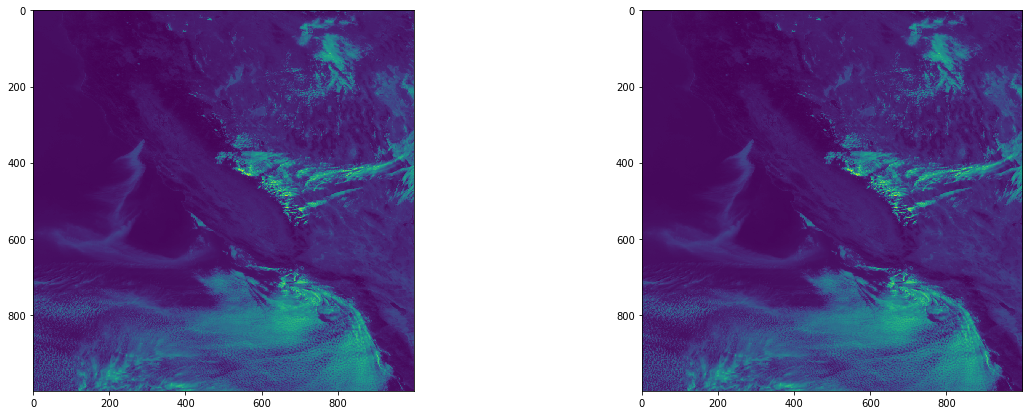

In [135]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 7))
axes[0].imshow(band_1.Rad)
axes[1].imshow(band_1.Rad * band_1.kappa0)

### Bands 7 - 16

1. un-scale??
2. convert to brightness temperature

T = [ fk2 / (alog((fk1 / Lλ) + 1)) - bc1 ] / bc2 

The
emissive bands support the characterization of the surface, clouds, water vapor, ozone, volcanic ash and
dust based on emissive properties.

In [107]:
band_7 = download_scan(s3_object=s3_resource.Object(bucket_name="noaa-goes17", key="ABI-L1b-RadM/2019/300/20/OR_ABI-L1b-RadM1-M6C07_G17_s20193002010275_e20193002010344_c20193002010380.nc"))

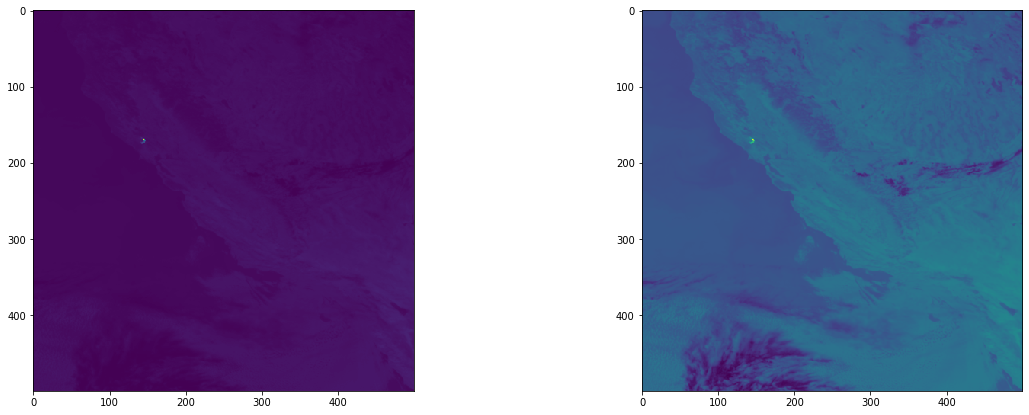

In [108]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 7))
axes[0].imshow(band_7.Rad)
axes[1].imshow((band_7.planck_fk2 / (np.log((band_7.planck_fk1 / band_7.Rad) + 1)) - band_7.planck_bc1) / band_7.planck_bc2)

In [ ]:
# dask_client = dask.distributed.Client(n_workers=2, threads_per_worker=2, memory_limit="1GB")

# with tempfile.NamedTemporaryFile() as file_path:
#     s3.download_file(Bucket=S3_BUCKET, Key=TEST_KEY, Filename=file_path.name)
#     ds = xr.open_dataset(file_path.name, chunks={"x": 1000, "y": 1000})